<a href="https://colab.research.google.com/github/hanbiphyun/ESSA_YB/blob/main/ESAA_YB_week6_2_%EB%B6%84%EB%A5%98_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**07.LightGBM**
: 부스팅 계열 알고리즘, 가장 각광 받는 중.
- 장점 : XGBoost보다 학습과 예측 수행 빠름, 작은 메모리 사용, 카테고리형 피처 자동 변환과 최적 분할
- 단점 : 적은 데이터 세트에서 과적합 발생 쉬움.
- 리프 중심 트리 분할 방식 : 최대 손실값(max delta loss)을 갖는 리프 노드를 분할시킴 -> 균형 트리 분할 방식보다 예측 오류 손실 최소화 O
- lightgbm 패키지 -> 파이썬 래퍼용/ 사이킷런 래퍼 (for 분류, 회귀)


In [1]:
import lightgbm
from lightgbm import LGBMClassifier

**LightGBM 하이퍼 파라미터**
- 주요 파라미터
  - num_iterations[defaulf=100] : 반복 수행하는 트리 개수 지정,클수록 성능 높지만 과적합 위험
  - learning_rate[default=0.1]
  - max_depth[default=-1] : 음수 지정 시 깊이 제한 없음, leaf wise 기반이어서 더 깊은 트리.
  - min_data_in_leaf[default=20] : 최종 결정 클래스인 리프 노드가 되기 위해 최소로 필요한 레코드 수, 과적합 제어
  - num_leaves[default=31] : 최대 리프 수
  - boosting[default= gbdt] -> 경사 부스팅 / 랜덤포레스트
  - bagging_fraction[default=1.0] : 데이터 샘플링하는 비율
  - labda_l2[default=0] : L2정규화 제어
  - labda_l1[default=0] : L1정규화 제어
- learning Task 파라미터
  - objective : 최솟값 가져야할 손실함수 정의
  
**하이퍼 파라미터 튜닝 방안**
: num_leaves 중심으로 min_child_samples, max_depth 조정하며 모델 복잡도 줄이기

**파이썬 래퍼 LightGBM / 사이킷런 래퍼 XGBoost / LightGBM 하이퍼 파라미터**
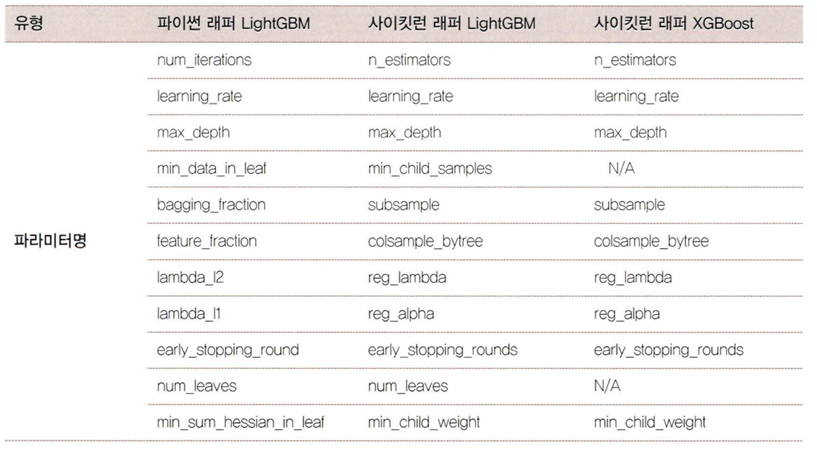

In [2]:
#LightGBM 적용- 위스콘신 유방암예측
#LightGBM 의 파이썬 패키지인 Lightgbm에서 LGBMClassifier 임포트

from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from lightgbm import early_stopping, log_evaluation

dataset= load_breast_cancer()

cancer_df= pd.DataFrame(data= dataset.data, columns= dataset.feature_names)
cancer_df['target']= dataset.target

X_features= cancer_df.iloc[:,:-1]
y_label= cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test= train_test_split(X_features, y_label, test_size= 0.2, random_state= 156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156)

#앞서 XGBoost와 동일하게 n_estimator는 400설정
lgbm_wrapper= LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals= [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=10)], eval_metric="logloss", eval_set=evals)
preds= lgbm_wrapper.predict(X_test)
pred_proba= lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):

    confusion=confusion_matrix(y_test, pred)

    accuracy=accuracy_score(y_test, pred)

    precision=precision_score(y_test, pred)

    recall=recall_score(y_test, pred)

    f1=f1_score(y_test, pred)

    #ROC-AUC 추가

    roc_auc=roc_auc_score(y_test, pred_proba)

    print('오차행렬')

    print(confusion)

    #ROC-AUC print 추가

    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall,f1,roc_auc))

get_clf_eval(y_test, preds, pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도:0.9561, 정밀도:0.9615, 재현율0.9740, F1:0.9677, AUC:0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

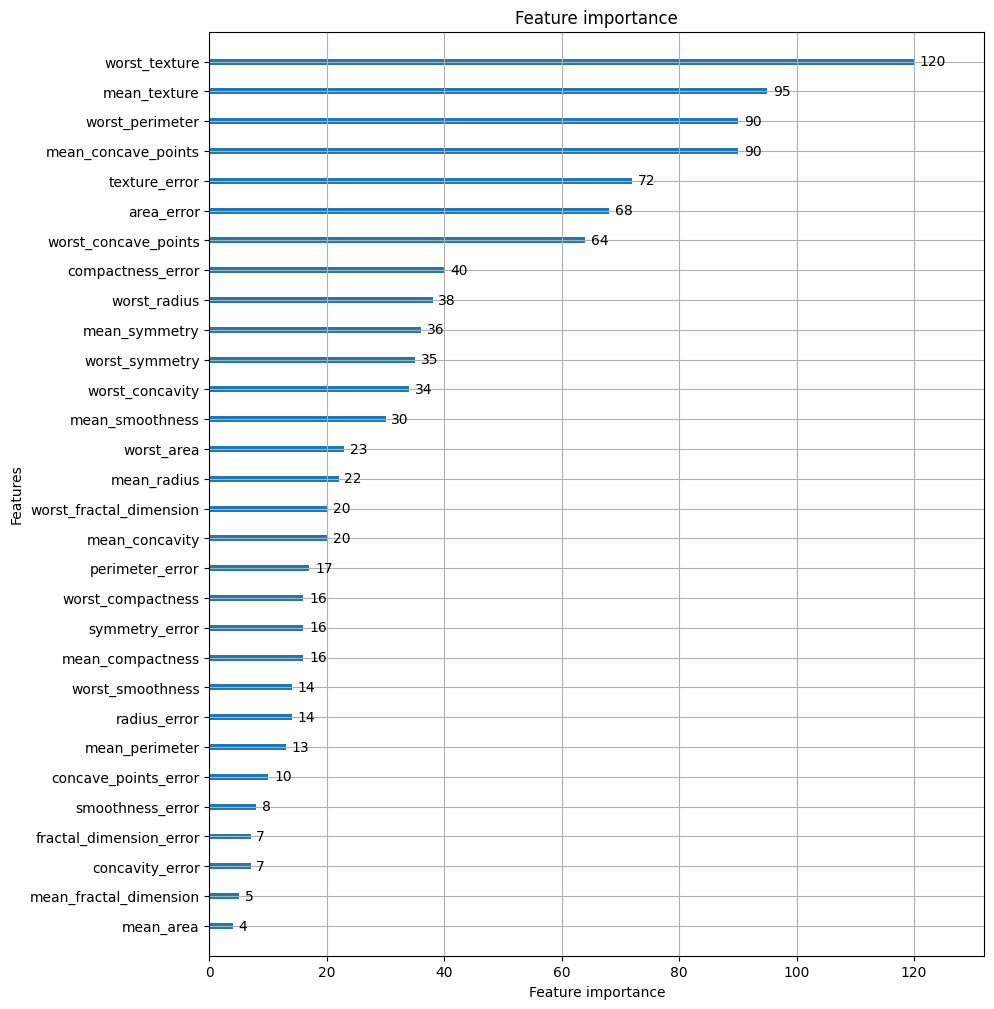

In [4]:
# plot_importance()를 이용하여 feature중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax= plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

###**08.베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**

> 이전의 Grid-Search 방식은 하이퍼 파라미터 개수가 많을수록 수행 시간이 너무 많이 소모되었다.

*베이지안 최적화*

: 가장 적은 시도로 목적 함수 식을 알수없는 형태의 함수에서 최대, 최소 함수 반환값을 만드는 최적 입력값 찾아주는 방식
- 새 데이터 입력받을 시 최적 함수를 예측하는 사후 모델을 개선해나감 -> 최적 함수 모델 만듬
- 구성 요소
  1. 대체 모델 : 획득 함수로부터 입력값 추천 받아 최적 함수 모델 개선해나감
  2. 획득 함수는 개선된 대체 모델로 최적 입력값(하이퍼 파라미터) 계산
   
- 최적화 단계
  1. 랜덤하게 하이퍼 파라미터 샘플링 & 관측
  2. 관측 값 기반으로 최적 함수 추정, 최적 관측값= y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터
  3. 추정된 최적 함수 기반으로 획득 함수가 다음 관측할 하이퍼 파라미터 값 계산 - 더 큰 최댓값 가질 지점을 찾아 그 파라미터를 대체 모델에 전달
  4. 전달된 하이퍼 파라미터 수행하여 대체 모델 갱신, 다시 최적함수 예측
  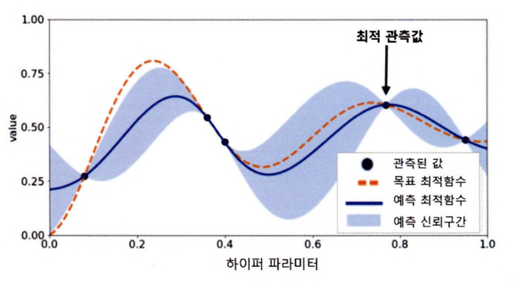
  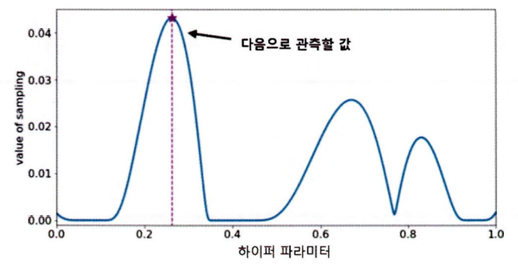
  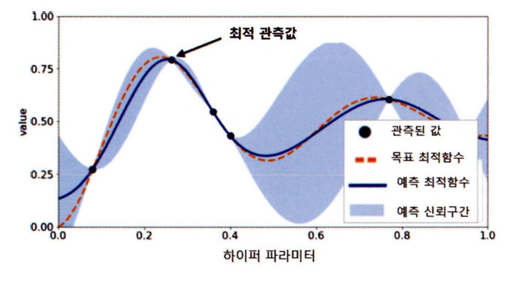

**HyperOpt 사용**
: 베이지안 최적화를 머신러닝 모델의 하이퍼 파라미터튜닝에 적용하도록 하는 파이썬 패키지
- 목적 함수 반환 값의 최솟값을 갖는 최적 입력값 유추 (최댓값 X)
- 입력 변수명, 입력값 검색 공간은 파이썬 딕셔너리 형태로 설정되어야함

**입력값의 검색 공간 제공하는 대표 함수들**

- hp.quniform(label, low, high, q)： labe로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을
가지고 설정.
- hp.uniform(label, low, high)： 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
- hp.randint(label, upper)： 0부터 최댓값 upper까지 random한 정숫값으로 검색 공간 설정.
- hp.loguniform(label, low, high)： exp(uniform(low, high)값을 반환하며, 반환 값의 log 변환 된 값은 정규 분포 형태를
가지는 검색 공간 설정.
- hp.choice(label, options)： 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정. Options는 리스트나 튜플 형
태로 제공되며 hp.choice('tree_criterion', ['gini', ’entropy’])과 같이 설정하면 입력 변수tree_criterion의 값을 ‘gini’
와 ‘entropy’로 설정하여 입력함.

*목적 함수 생성*

: 반드시 변숫값과 검색 공간을 갖는 딕셔너리를 인자로 받으며 특정 값 반환해야함

*최적의 입력값 찾기*
- fmin(objective, space, algo, max_evals, trials) 함수 제공 -> 기능 수행
  - 주요 인자
    - fn : 목적함수
    - space : 검색 공간 딕셔너리
    - algo : 베이지안 최적화 적용 알고리즘, 기본값 tpe.suggest
    - max_evals : 최적 입력값을 찾기 위한 시도 횟수
    - trials : 시도한 입력값 (vals- 딕셔너리 형태) 및 해당 입력값의 목적 함수 반환값 (results- 파이썬 리스트 형태) 결과 저장
    - rstate : 랜덤 시드값

In [5]:
!pip install scikit-learn==1.5.2 --force-reinstall


  Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully u

In [6]:
from hyperopt import hp

# -10 ~ 10 까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space= {'x': hp.quniform('x',-10,10,1), 'y': hp.quniform('y',-15,15,1)}

In [7]:
from hyperopt import STATUS_OK

# 목적 함수를 생성, 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x= search_space['x']
    y=search_space['y']
    retval= x**2- 20*y

    return retval

In [8]:
import numpy as np
from hyperopt import fmin, tpe, Trials
# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val=Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01=fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 363.65trial/s, best loss: -224.0]
best: {'x': np.float64(-4.0), 'y': np.float64(12.0)}


In [9]:
trial_val=Trials()

#max_evals를 20회로 늘려서 재테스트
best_02=fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 746.53trial/s, best loss: -296.0]
best: {'x': np.float64(2.0), 'y': np.float64(15.0)}


In [10]:
# fmin() 에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss'：함수 반환값, ‘status'：반환 상태값}와 같은 딕셔너리임.
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [11]:
 # Trials 객체의 vals 속성에 {'입력변수명': 개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [np.float64(-6.0), np.float64(-4.0), np.float64(4.0), np.float64(-4.0), np.float64(9.0), np.float64(2.0), np.float64(10.0), np.float64(-9.0), np.float64(-8.0), np.float64(-0.0), np.float64(-0.0), np.float64(1.0), np.float64(9.0), np.float64(6.0), np.float64(9.0), np.float64(2.0), np.float64(-2.0), np.float64(-4.0), np.float64(7.0), np.float64(-0.0)], 'y': [np.float64(5.0), np.float64(10.0), np.float64(-2.0), np.float64(12.0), np.float64(1.0), np.float64(15.0), np.float64(7.0), np.float64(-10.0), np.float64(0.0), np.float64(-5.0), np.float64(-3.0), np.float64(2.0), np.float64(4.0), np.float64(10.0), np.float64(3.0), np.float64(3.0), np.float64(-14.0), np.float64(-8.0), np.float64(11.0), np.float64(-0.0)]}


In [12]:
import pandas as pd
# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성.
losses=[loss_dict['loss'] for loss_dict in trial_val.results]


# DataFrame으로 생성 .
result_df = pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


**HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화**
- 주의할점 :
1. 하이퍼 파라미터 입력 시 형변환 해주기 (실수->정수)
2. HyperOpt의 목적함수는 최솟값을 반환하도록 해야해서 -1 곱해주기
  - 0.8 vs 0.9 -> 0.9 선택해야하는데 fmin()은 최솟값을 최적화하기에 -1 붙여서 더 작은 값인 -0.9 선택하도록 함

In [13]:
 # 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [14]:
from hyperopt import hp

# 하이퍼 파라미터 검색공간 설정
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규분포된 값으로 검색

xgb_search_space= {'max_depth': hp.quniform('max_depth', 5,20,1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), }

In [15]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

#fmin() 에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
#XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야함.
# 정확도는 높을수록 더 좋은 수치임. -1*정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf=XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          learning_rate=search_space['learning_rate'],
                          colsample_bytree=search_space['colsample_bytree'],
                          eval_metric='logloss')
    accuracy=cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    #accuracy는 cv=3 개수만큼 roc-auc결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1*np.mean(accuracy), 'status': STATUS_OK}

In [16]:
from hyperopt import fmin, tpe, Trials

trial_val=Trials()
best= fmin(fn=objective_func,
           space= xgb_search_space,
           algo= tpe.suggest,
           max_evals=50,   #최대 반복 횟수를 지정합니다.
           trials= trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:33<00:00,  1.48trial/s, best loss: -0.9692546764261648]
best: {'colsample_bytree': np.float64(0.5803491295375391), 'learning_rate': np.float64(0.14050096981854135), 'max_depth': np.float64(17.0), 'min_child_weight': np.float64(2.0)}


In [17]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.58035, learning_rate:0.1405, max_depth:17, min_child_weight:2


In [18]:
import importlib
import xgboost
importlib.reload(xgboost)


<module 'xgboost' from '/usr/local/lib/python3.12/dist-packages/xgboost/__init__.py'>

In [22]:
from xgboost.callback import EarlyStopping
xgb_wrapper= XGBClassifier(n_estimators=400,
                           learning_rate= round(best['learning_rate'],5),
                           max_depth=int(best['max_depth']),
                           colsample_bytree=round(best['colsample_bytree'],5))

evals=[(X_tr, y_tr),(X_val, y_val)]

xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)

preds= xgb_wrapper.predict(X_test)
pred_proba= xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.57617	validation_1-logloss:0.61145
[1]	validation_0-logloss:0.48663	validation_1-logloss:0.55317
[2]	validation_0-logloss:0.41467	validation_1-logloss:0.49635
[3]	validation_0-logloss:0.35802	validation_1-logloss:0.45194
[4]	validation_0-logloss:0.31197	validation_1-logloss:0.41646
[5]	validation_0-logloss:0.27168	validation_1-logloss:0.38474
[6]	validation_0-logloss:0.23830	validation_1-logloss:0.36212
[7]	validation_0-logloss:0.20912	validation_1-logloss:0.34609
[8]	validation_0-logloss:0.18529	validation_1-logloss:0.33120
[9]	validation_0-logloss:0.16483	validation_1-logloss:0.32093
[10]	validation_0-logloss:0.14653	validation_1-logloss:0.30690
[11]	validation_0-logloss:0.13136	validation_1-logloss:0.29912
[12]	validation_0-logloss:0.11804	validation_1-logloss:0.29086
[13]	validation_0-logloss:0.10639	validation_1-logloss:0.28038
[14]	validation_0-logloss:0.09645	validation_1-logloss:0.27631
[15]	validation_0-logloss:0.08807	validation_1-logloss:0.27225
[1

###**11.스태킹 앙상블**
: 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출
- 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측 수행 = 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별로의 ML 알고리즘 -> 최종 학습 수행 + 테스트 데이터 기반으로 다시 최종 예측 수행 (=메타 모델)
- 모델 1. 개별적인 기반 모델
- 모델 2. 최종 메타 모델
- 핵심 : 여러 개별 모델을 스태킹 형태로 결합해 최종 메타 모델의 학습용/ 테스트용 피처 데이터 세트 만들기
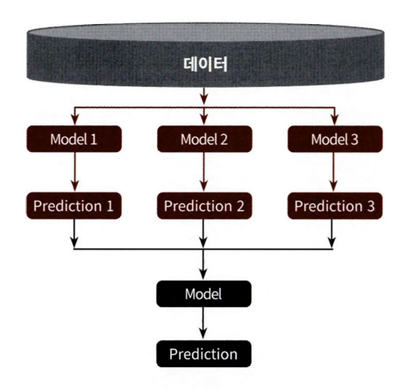
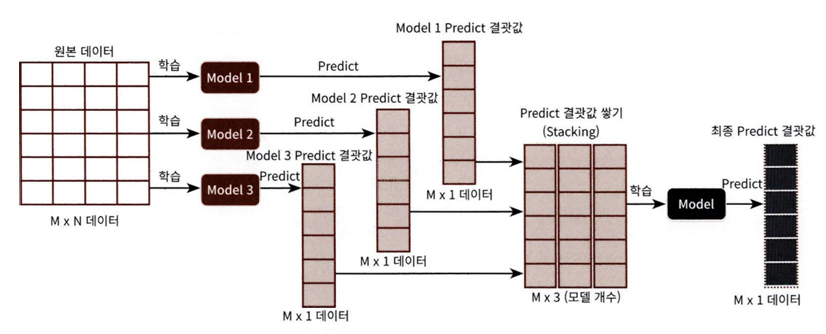

In [23]:
#기본 스태킹 모델
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [25]:
# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression()

#개별 모델들을 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [26]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [27]:
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도: 0.9737


**CV 세트 기반의 스태킹**
- 과적합 개선하기 위해 교차 검증 기반으로 예측된 결과 데이터 세트 이용해 최종 메타 모델 생성

■ 스텝 1： 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를
생성합니다.

■ 스텝2： 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데
이터 세트를 생성합니다. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측
할 최종 테스트 데이터 세트를 생성합니다. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이
블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이
터를 기반으로 평가합니다.
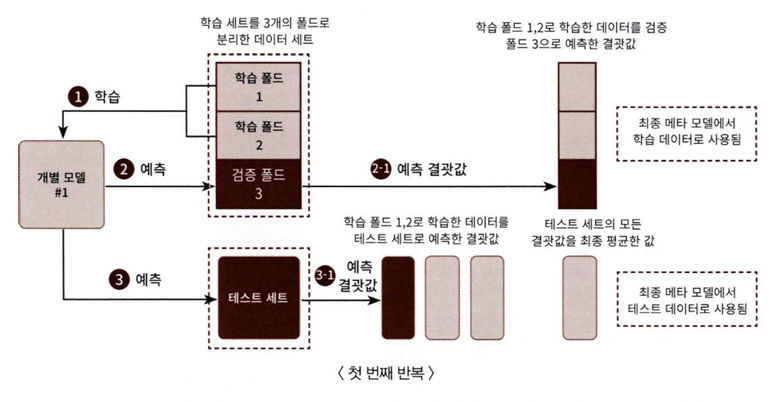
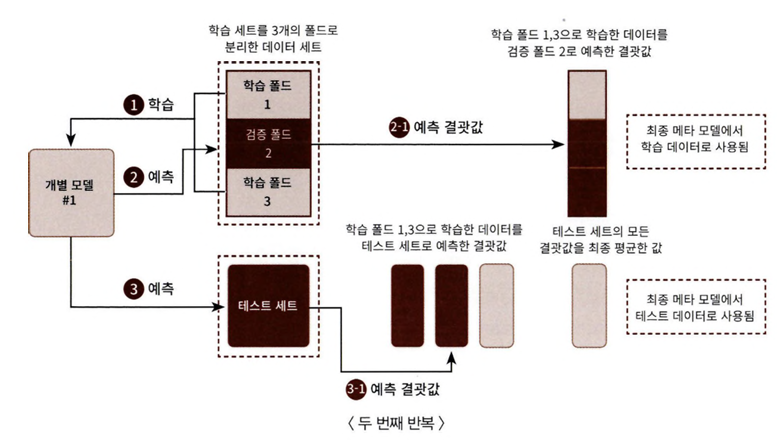
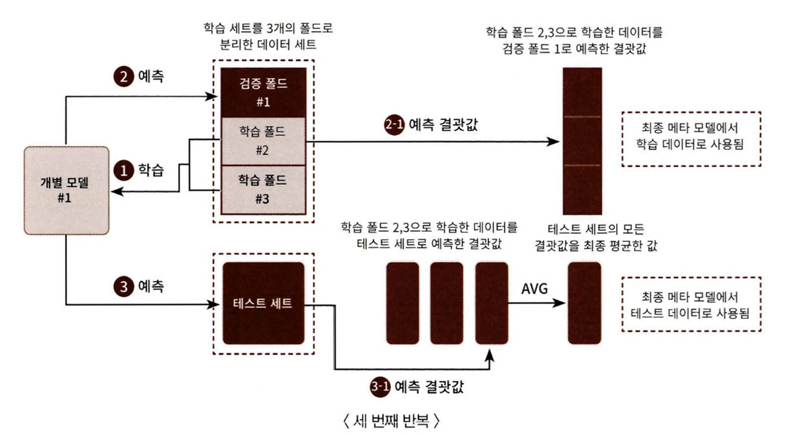

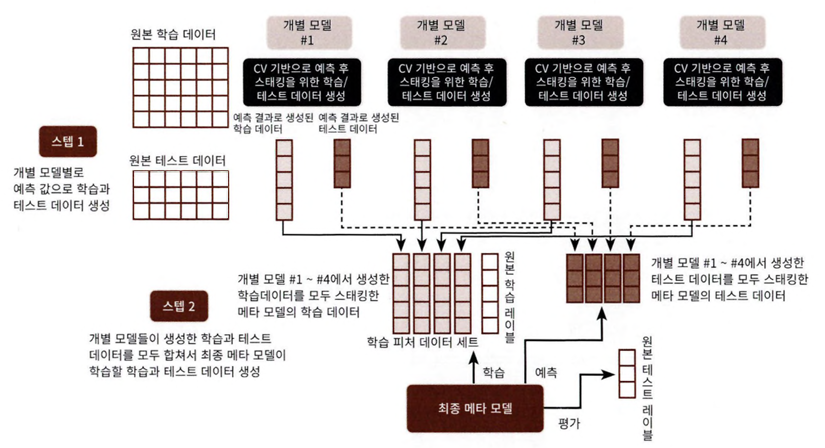

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):

# 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
 # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1 ))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print (model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1, 1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

# 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1 ).reshape(-1, 1)
# train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [32]:
knn_train, knn_test= get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트: 0  시작
	 폴드 세트: 1  시작
	 폴드 세트: 2  시작
	 폴드 세트: 3  시작
	 폴드 세트: 4  시작
	 폴드 세트: 5  시작
	 폴드 세트: 6  시작
RandomForestClassifier model 시작
	 폴드 세트: 0  시작
	 폴드 세트: 1  시작
	 폴드 세트: 2  시작
	 폴드 세트: 3  시작
	 폴드 세트: 4  시작
	 폴드 세트: 5  시작
	 폴드 세트: 6  시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0  시작
	 폴드 세트: 1  시작
	 폴드 세트: 2  시작
	 폴드 세트: 3  시작
	 폴드 세트: 4  시작
	 폴드 세트: 5  시작
	 폴드 세트: 6  시작
AdaBoostClassifier model 시작
	 폴드 세트: 0  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트: 1  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트: 2  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트: 3  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트: 4  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트: 5  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트: 6  시작


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [39]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape：',Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape： (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [41]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
